In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import (
    train_test_split,
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import (
    GradientBoostingClassifier,
    AdaBoostClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier

### Load the data

In [2]:
data = pd.read_csv("..\\Data\\BP_features.csv")
labels = pd.read_csv("..\\Data\\BP_labels_diastolic.csv")

In [3]:
labels["min_BP"]

0      80
1      80
2      70
3      80
4      70
       ..
547    77
548    74
549    82
550    70
551    81
Name: min_BP, Length: 552, dtype: int64

In [4]:
def get_binary_class(value):
    # Normal Class for Max_BP (90-140)
    if value < 60:
        return -1
    elif value >= 60 and value <= 90:
        return 0
    # Abnormal Class for Max_BP (<90) or (>140)
    return 1

labels = labels["min_BP"].apply(lambda x: get_binary_class(x))

In [5]:
labels.value_counts()

min_BP
 0    464
 1     70
-1     18
Name: count, dtype: int64

In [6]:
# Create a boolean mask to filter out rows where labels are -1
mask = labels != -1
mask


labels = pd.Series(labels)
# Apply the mask to both data and labels to drop rows with labels = -1
data = data[mask]
labels = labels[mask]

# Reset index to keep them aligned if necessary
data.reset_index(drop=True, inplace=True)
labels.reset_index(drop=True, inplace=True)

# Check the resulting shapes to confirm
print(f"Shape of data: {data.shape}")
print(f"Shape of labels: {labels.shape}")

Shape of data: (534, 124)
Shape of labels: (534,)


In [7]:
labels = np.ravel(labels)

### Splitting the Dataset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, shuffle=True
)

In [9]:
y_train.shape

(427,)

### Normalization

In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
X_train[0]

array([4.32835821e-01, 1.00000000e+00, 4.93333333e-01, 1.00000000e+00,
       9.09090909e-02, 6.00000000e-01, 2.85714286e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.09829681e-15,
       7.54901961e-01, 3.81642512e-01, 1.16070340e-15, 1.34723239e-30,
       3.11418685e-02, 4.73684211e-01, 1.15755627e-01, 4.66833408e-16,
       2.17933431e-31, 3.39890809e-01, 1.19399449e-01, 0.00000000e+00,
       1.19140655e-01, 1.19512055e-01, 2.69144976e-15, 1.00000000e+00,
       9.15254237e-01, 2.34320138e-15, 5.49059269e-30, 4.34782609e-02,
       1.00000000e+00, 1.34453782e-01, 1.33433746e-15, 1.78045645e-30,
       6.24661247e-01, 3.89794477e-01, 0.00000000e+00, 3.91272490e-01,
       3.91272490e-01, 2.08166817e-15, 9.42693410e-01, 3.73801917e-01,
       8.04922302e-16, 6.47899913e-31, 3.61445783e-02, 3.10344828e-01,
      

### Train and evaluate model

In [12]:
def train_evaluate_model(X_train, X_test, y_train, y_test, model, param_grid):

    bayes_search = BayesSearchCV(
        model,
        param_grid,
        cv=5,
        scoring="f1_macro",
        n_jobs=-1,
        random_state=42,
        n_iter=20,
    )
    bayes_search.fit(X_train, y_train)

    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Evaluation Metrics!
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    try:
        train_roc = roc_auc_score(y_train, bayes_search.predict_proba(X_train)[:, 1])
        test_roc = roc_auc_score(y_test, bayes_search.predict_proba(X_test)[:, 1])

    except:
        test_roc = roc_auc_score(y_test, bayes_search.decision_function(X_test))
        train_roc = roc_auc_score(y_train, bayes_search.decision_function(X_train))

    return (
        best_model,
        best_params,
        train_accuracy,
        test_accuracy,
        train_f1,
        test_f1,
        train_roc,
        test_roc,
    )

Parameter Grid for different models

In [13]:
models = {
    "Logistic Regression": [
        LogisticRegression(
            max_iter=2000, n_jobs=-1, random_state=42, class_weight="balanced"
        ),
        {
            "C": Real(0.01, 10, prior="log-uniform"),
            "fit_intercept": [True, False],
            "penalty": ["l2", None],
            "solver": ["lbfgs", "newton-cg", "newton-cholesky", "sag"],
            # "tol": Real(1e-5, 1e-3, prior="log-uniform"),
        },
    ],
    "Ridge Regression": [
        RidgeClassifier(random_state=42, max_iter=2000, class_weight="balanced"),
        {
            "alpha": Real(0.01, 100, prior="log-uniform"),
            "fit_intercept": [True, False],
        },
    ],
    "SVM": [
        SVC(random_state=42, class_weight="balanced", probability=True, kernel="poly"),
        {
            # "gamma": Categorical(["scale", "auto"]),
            'gamma': Real(1e-3, 1, prior="log-uniform"),
            "C": Real(1e-2, 100, prior="log-uniform"),
            'degree': Integer(2, 8),
            'coef0': Real(1e-1, 10, prior="log-uniform")
            
            # "kernel": Categorical(["linear", "poly", "rbf", "sigmoid"]),
        },
    ],
    "Decision Tree": [
        DecisionTreeClassifier(random_state=42, class_weight="balanced"),
        {
            "max_depth": Integer(3, 8),
            "criterion": Categorical(["gini", "entropy", "log_loss"]),
            # "min_samples_split": Integer(2, 10),
            # "min_samples_leaf": Integer(1, 10),
            'max_leaf_nodes': Integer(3,10)
        },
    ],
    "KNN": [
        KNeighborsClassifier(),
        {
            "metric": Categorical(["euclidean", "manhattan"]),
            "n_neighbors": Integer(3, 30),
            "weights": Categorical(["uniform", "distance"]),
            "algorithm": Categorical(["auto", "ball_tree", "kd_tree", "brute"]),
            "p": Integer(1, 2),
        },
    ],
    "AdaBoost": [
        AdaBoostClassifier(random_state=42, algorithm="SAMME"),
        {
            "n_estimators": Integer(50, 210),
            "learning_rate": Real(0.001, 1, prior="log-uniform"),
        },
    ],
    "Random Forest": [
        RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced"),
        {
            "n_estimators": Integer(50, 500),
            "max_depth": Integer(3, 20),
            "min_samples_split": Integer(2, 100),
            "min_samples_leaf": Integer(1, 50),
            "max_features": Categorical(["sqrt", "log2", None]),
            "bootstrap": Categorical([True, False]),
            "criterion": Categorical(["gini", "entropy", "log_loss"]),
        },
    ],
    "Gradient Boosting": [
        GradientBoostingClassifier(random_state=42),
        {
            # "criterion": Categorical(["friedman_mse", "squared_error"]),
            "n_estimators": Integer(50, 300),
            "learning_rate": Real(1e-4, 0.01, prior="log-uniform"),
            "max_depth": Integer(3, 8),
            # "min_samples_split": Integer(10, 50),
            # "min_samples_leaf": Integer(5, 30),
            # "n_iter_no_change": Integer(5, 20),
        },
    ],
    "XGBoost": [
        XGBClassifier(n_jobs=-1, random_state=42),
        {
            "n_estimators": Integer(50, 200),
            "learning_rate": Real(1e-4, 0.01, prior="log-uniform"),
            "max_depth": Integer(3, 8),
            "colsample_bytree": Real(0.6, 0.9),
            # "gamma": Real(1, 5, prior="log-uniform"),
            # "reg_alpha": Real(1, 5, prior="log-uniform"),
            # "reg_lambda": Real(1, 10, prior="log-uniform"),
            # "min_child_weight": Integer(3, 10),
            "scale_pos_weight": Real(5, 10),
        },
    ],
    "Naive Bayes": (
        GaussianNB(),
        {"var_smoothing": Real(1e-6, 1e-2, prior="log-uniform")},
    ),
    "BernoulliNB": (BernoulliNB(), {"alpha": Real(0.001, 1, prior="log-uniform")}),
    "Light GBM": [
        LGBMClassifier(
            n_jobs=-1, random_state=42, class_weight="balanced", verbosity=-1
        ),
        {
            # "reg_alpha": Real(1, 10, prior="log-uniform"),
            # "reg_lambda": Real(1, 10, prior="log-uniform"),
            "num_leaves": Integer(10, 50),
            "max_depth": Integer(3, 8),
            "learning_rate": Real(1e-4, 1e-2, prior="log-uniform"),
            "n_estimators": Integer(100, 500),
            "min_child_samples": Integer(20, 60),
            # "subsample": Real(0.6, 1.0),
            "colsample_bytree": Real(0.5, 0.8),
        },
    ],
}

In [14]:
best_models = {}
results = []

In [15]:
for model_name, (model, param_grid) in models.items():
    print("Model:", model_name)
    (
        best_model,
        best_params,
        train_accuracy,
        test_accuracy,
        train_f1,
        test_f1,
        train_roc,
        test_roc,
    ) = train_evaluate_model(X_train, X_test, y_train, y_test, model, param_grid)
    best_models[model_name] = best_model
    item = {
        "Model": model_name,
        "Train Accuracy": np.round(train_accuracy * 100, 2),
        "Test Accuracy": np.round(test_accuracy * 100, 2),
        "Train F1": np.round(train_f1 * 100, 2),
        "Test F1": np.round(test_f1 * 100, 2),
        "Train ROC": np.round(train_roc * 100, 2),
        "Test ROC": np.round(test_roc * 100, 2),
        "Best Parameters": best_params,
    }
    print(item)
    results.append({
        "Model": model_name,
        "Train Accuracy": np.round(train_accuracy * 100, 2),
        "Test Accuracy": np.round(test_accuracy * 100, 2),
        "Train F1": np.round(train_f1 * 100, 2),
        "Test F1": np.round(test_f1 * 100, 2),
        "Train ROC": train_roc,
        "Test ROC": test_roc,
        # "Best Parameters": best_params,
    })

Model: Logistic Regression


c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


{'Model': 'Logistic Regression', 'Train Accuracy': 92.04, 'Test Accuracy': 79.44, 'Train F1': 75.36, 'Test F1': 45.0, 'Train ROC': 97.68, 'Test ROC': 65.29, 'Best Parameters': OrderedDict({'C': 0.16994636371262764, 'fit_intercept': False, 'penalty': None, 'solver': 'newton-cg'})}
Model: Ridge Regression
{'Model': 'Ridge Regression', 'Train Accuracy': 69.09, 'Test Accuracy': 74.77, 'Train F1': 34.0, 'Test F1': 40.0, 'Train ROC': 71.86, 'Test ROC': 68.24, 'Best Parameters': OrderedDict({'alpha': 45.233439032636454, 'fit_intercept': True})}
Model: SVM
{'Model': 'SVM', 'Train Accuracy': 87.35, 'Test Accuracy': 81.31, 'Train F1': 65.82, 'Test F1': 50.0, 'Train ROC': 95.11, 'Test ROC': 75.82, 'Best Parameters': OrderedDict({'C': 0.4369339947510315, 'coef0': 2.8539836866041823, 'degree': 8, 'gamma': 0.00885928719200224})}
Model: Decision Tree
{'Model': 'Decision Tree', 'Train Accuracy': 74.0, 'Test Accuracy': 77.57, 'Train F1': 44.78, 'Test F1': 45.45, 'Train ROC': 84.06, 'Test ROC': 70.26, '

c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.002219530691704e-06] before, using random point [2.0099688090598323e-05]
  warnings.warn(
c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0004457650991489e-06] before, using random point [5.66945860133747e-06]
  warnings.warn(
c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.000342313282149e-06] before, using random point [0.00350068974143221]
  warnings.warn(
c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0011782755796267e-06] before, using random point [0.00014147963402677167]


{'Model': 'Naive Bayes', 'Train Accuracy': 33.26, 'Test Accuracy': 33.64, 'Train F1': 26.36, 'Test F1': 29.7, 'Train ROC': 59.73, 'Test ROC': 54.08, 'Best Parameters': OrderedDict({'var_smoothing': 1.0340016434251914e-06})}
Model: BernoulliNB
{'Model': 'BernoulliNB', 'Train Accuracy': 78.22, 'Test Accuracy': 82.24, 'Train F1': 32.12, 'Test F1': 42.42, 'Train ROC': 70.13, 'Test ROC': 65.1, 'Best Parameters': OrderedDict({'alpha': 0.187606709700378})}
Model: Light GBM
{'Model': 'Light GBM', 'Train Accuracy': 87.35, 'Test Accuracy': 84.11, 'Train F1': 66.25, 'Test F1': 56.41, 'Train ROC': 96.73, 'Test ROC': 85.95, 'Best Parameters': OrderedDict({'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 60, 'n_estimators': 500, 'num_leaves': 50})}


In [16]:
results = pd.DataFrame(results)
results

,Model,Train Accuracy,Test Accuracy,Train F1,Test F1,Train ROC,Test ROC
0,Logistic Regression,92.04,79.44,75.36,45.00,0.976793,0.652941
1,Ridge Regression,69.09,74.77,34.00,40.00,0.718595,0.682353
2,SVM,87.35,81.31,65.82,50.00,0.951064,0.758170
3,Decision Tree,74.00,77.57,44.78,45.45,0.840556,0.702614
4,KNN,100.00,80.37,100.00,27.59,1.000000,0.640523
5,AdaBoost,93.91,85.98,68.29,28.57,0.983781,0.777778
6,Random Forest,84.31,84.11,52.48,45.16,0.899556,0.756209
7,Gradient Boosting,100.00,87.85,100.00,48.00,1.000000,0.707190
8,XGBoost,89.46,87.85,64.00,55.17,0.940899,0.730065
9,Naive Bayes,33.26,33.64,26.36,29.70,0.597266,0.540850


### Ensemble

#### Stacking Classifier

In [21]:
base_models = [
    "XGBoost",
    "Light GBM",
    "SVM",
    # "Decision Tree",
    "AdaBoost",
    "Naive Bayes",
    # 'Random Forest'
]


meta_model = best_models["Logistic Regression"]
evaluation_results2 = []
base = []
for model in base_models:
    base.append((model, best_models[model]))

stack = StackingClassifier(
    estimators=base,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    stack_method="predict_proba",
)

stack.fit(X_train, y_train)

y_pred_test = stack.predict(X_test)


train_acc = accuracy_score(y_train, stack.predict(X_train)) * 100
train_f1 = f1_score(y_train, stack.predict(X_train)) * 100
train_roc = roc_auc_score(y_train, stack.predict_proba(X_train)[: , 1]) * 100

test_acc = accuracy_score(y_test, y_pred_test) * 100
test_f1 = f1_score(y_test, y_pred_test) * 100
test_roc = roc_auc_score(y_test, stack.predict_proba(X_test)[: , 1]) * 100

evaluation_results2.append(
    {
        "Train Accuracy": np.round(train_acc, 2),
        "Train F1 Score": np.round(train_f1, 2),
        "Train ROC AUC Score": np.round(train_roc, 2),
        "Test Accuracy": np.round(test_acc, 2),
        "Test F1 Score": np.round(test_f1, 2),
        "Test ROC AUC Score": np.round(test_roc, 2),  
    }
)

results2 = pd.DataFrame(data=evaluation_results2).T
results2

c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


,0
Train Accuracy,80.56
Train F1 Score,56.08
Train ROC AUC Score,96.60
Test Accuracy,82.24
Test F1 Score,59.57
Test ROC AUC Score,87.32


In [17]:
import seaborn as sns

In [51]:
plt.rcParams.update(plt.rcParamsDefault)

In [49]:
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
})


In [22]:
cm = confusion_matrix(y_test, y_pred_test)

In [23]:
cm

array([[74, 16],
       [ 3, 14]], dtype=int64)

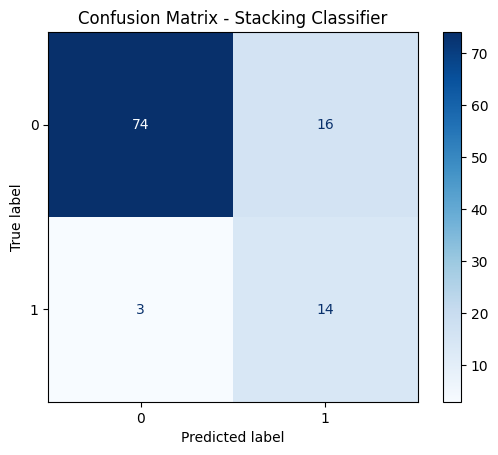

In [24]:
# Compute confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Stacking Classifier')
plt.show()


#### Voting Classifier

In [25]:
from sklearn.ensemble import VotingClassifier

model_names = [
    "XGBoost",
    "Light GBM",
    # "Decision Tree",
    "SVM",
    "AdaBoost",
    # "Naive Bayes",
    # "BernoulliNB",
    # "Logistic Regression",
    # "Gradient Boosting"
    
]

evaluation_results2 = []
base = []
for j in range(len(model_names)):
    base.append((model_names[j], best_models[model_names[j]]))

stack = VotingClassifier(
    estimators=base,
    n_jobs=-1,
    voting="soft",
    weights=[0.8,1.4,0.3, 0.4],
)
stack.fit(X_train, y_train)

y_pred_test = stack.predict(X_test)

train_acc = accuracy_score(y_train, stack.predict(X_train)) * 100 
train_f1 = f1_score(y_train, stack.predict(X_train)) * 100
train_roc = roc_auc_score(y_train, stack.predict_proba(X_train)[: , 1]) * 100
test_acc = accuracy_score(y_test, y_pred_test) * 100
test_f1 = f1_score(y_test, y_pred_test) * 100
test_roc = roc_auc_score(y_test, stack.predict_proba(X_test)[: , 1]) * 100

evaluation_results2.append(
    {
        "Train Accuracy": np.round(train_acc, 2),
        "Train F1 Score": np.round(train_f1, 2),
        "Train ROC AUC Score": np.round(train_roc, 2),
        "Test Accuracy": np.round(test_acc, 2),
        "Test F1 Score": np.round(test_f1, 2),
        "Test ROC AUC Score": np.round(test_roc, 2),  
    }
)

results2 = pd.DataFrame(data=evaluation_results2).T
results2


,0
Train Accuracy,90.87
Train F1 Score,71.53
Train ROC AUC Score,96.92
Test Accuracy,90.65
Test F1 Score,64.29
Test ROC AUC Score,85.03


Text(0.5, 1.0, 'Confusion Matrix - Voting Classifier')

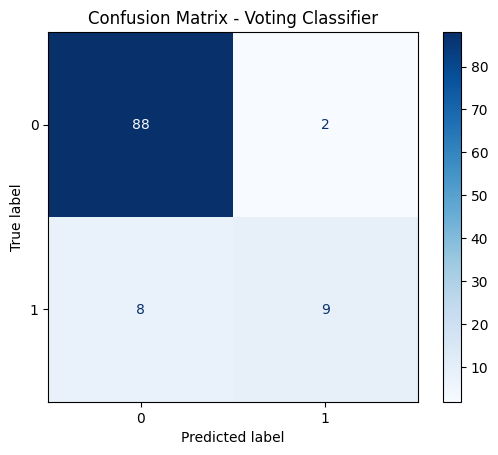

In [26]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Voting Classifier')
